In [1]:
from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model as lm

In [2]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

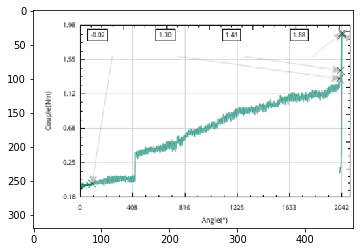

In [3]:
# Load data
img_PIL = Image.open('test_image.png')
img = np.array(img_PIL)[:,:,:3]
img_gray = rgb2gray(img)
plt.imshow(img)
#plt.imshow(img_gray, cmap=plt.cm.gray)

In [4]:
print("Image shape is: " + str(img.shape))

Image shape is: (320, 470, 3)


In [25]:
# Extract data points
h, w, c = img.shape
X = []
y = []

img_extract = img.copy()

for i in range(h):
    for j in range(w):
        r = img[i,j,0]
        g = img[i,j,1]
        b = img[i,j,2]
        if 60 <= r <= 160 and 160 <= g <= 210 and 130 <= b <= 200:
            img_extract[i,j,:] = np.array([255,0,0], dtype=np.uint8)
            X.append(j)
            y.append(i)
        else:
            pass
X = np.array(X)[:,np.newaxis]
y = np.array(y)[:,np.newaxis]
#img_extract[min_point[0], min_point[1], :] = np.array([0,255,0], dtype=np.uint8)


In [26]:
def valid_data_line2(X,y):
    if (np.max(X) - np.min(X)) < 5 and np.mean(X) > w/2:
        return True
    else:
        return False

def valid_model_line2 (model, X, y):
    k = model.coef_
    if k < -20:
        return True
    else:
        return False



In [27]:
# RANSAC find line
ransac = lm.RANSACRegressor(max_trials=1000,is_data_valid=valid_data_line2, is_model_valid=valid_model_line2)
ransac.fit(X,y)
k = ransac.estimator_.coef_
b = ransac.estimator_.intercept_
print("Line function is: y = {k}x + {b} ".format(k=str(round(k[0][0], 3)), b=str(round(b[0],3))))



Line function is: y = -110.032x + 49957.081 


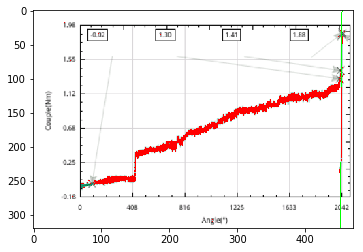

In [28]:
if abs(k) < 1:
    line_X = np.arange(w)[:,np.newaxis]
    line_Y = ransac.predict(line_X).astype(int)
    for i in range(line_X.shape[0]):
        img_x = line_X[i,0]
        img_y = line_Y[i,0]
        img_extract[img_y,img_x,:] = np.array([0,255,0], dtype=np.uint8)
else:
    line_Y = np.arange(h)[:,np.newaxis]
    line_X = ((line_Y - b)/k).astype(int)
    for i in range(line_Y.shape[0]):
        img_x = line_X[i,0]
        img_y = line_Y[i,0]
        img_extract[img_y,img_x,:] = np.array([0,255,0], dtype=np.uint8)
plt.imshow(img_extract)


In [60]:
im = Image.fromarray(np.uint8(img_extract))
im.save('extract_img.png')

In [32]:
im = cv2.imread("test_image.png", cv2.IMREAD_COLOR)
print(type(im))
print(im.shape)

<class 'numpy.ndarray'>
(320, 470, 3)
